In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.metrics import r2_score , mean_squared_error , mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV 
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel("premiums_rest.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [3]:
df.shape

(29904, 13)

## 1). Data Cleaning & EDA

In [4]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [5]:
df.columns = df.columns.str.replace(' ' , '_').str.lower()

In [6]:
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


### Handle NA Values

In [7]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [8]:
df.dropna(inplace = True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [9]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

### Handle Outliers

In [10]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


In [11]:
df[df.number_of_dependants < 0].shape

(50, 13)

In [12]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-1, -3], dtype=int64)

In [13]:
# 'number_of_dependants' column contain -3 and -1 values for 72 rows

In [14]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [15]:
numeric_columns = df.select_dtypes(['float64' , 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

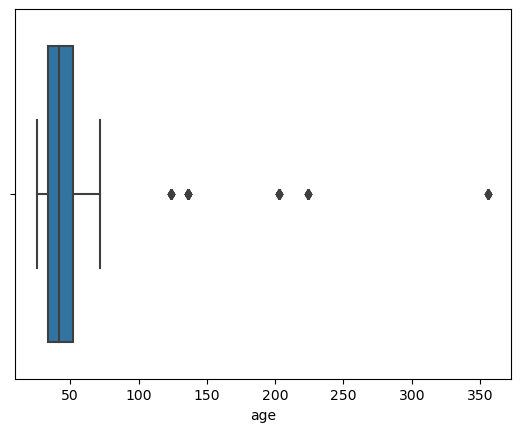

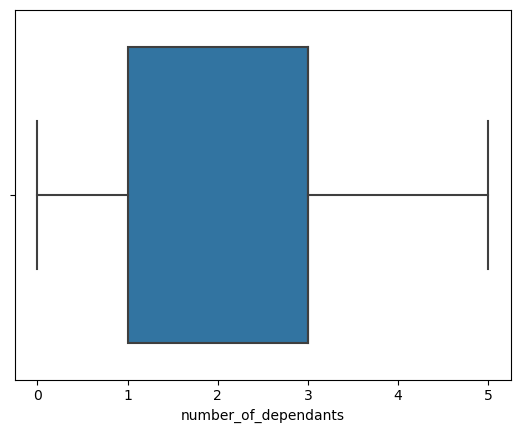

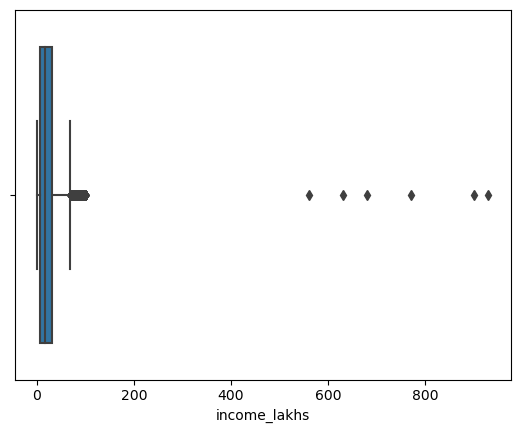

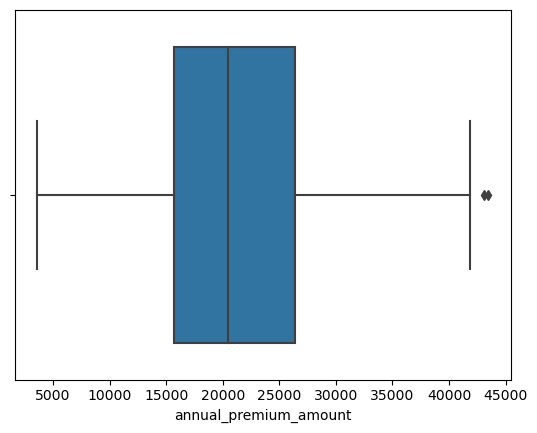

In [16]:
for col in numeric_columns:
    sns.boxplot(x = df[col])
    plt.show()

In [17]:
df[df.age > 100]['age'].unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [18]:
df1 = df[df.age <=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


In [19]:
df1.income_lakhs.quantile([0.25 , 0.75])

0.25     7.0
0.75    32.0
Name: income_lakhs, dtype: float64

In [20]:
def get_iqr_bounds(col):
    Q1 , Q3 = col.quantile([0.25 , 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound , upper_bound
    

In [21]:
get_iqr_bounds(df1.income_lakhs)

(-30.5, 69.5)

In [22]:
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

100.0

In [23]:
df1[df1.income_lakhs > quantile_thresold].shape

(6, 13)

In [24]:
df2 = df1[df1.income_lakhs <= quantile_thresold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


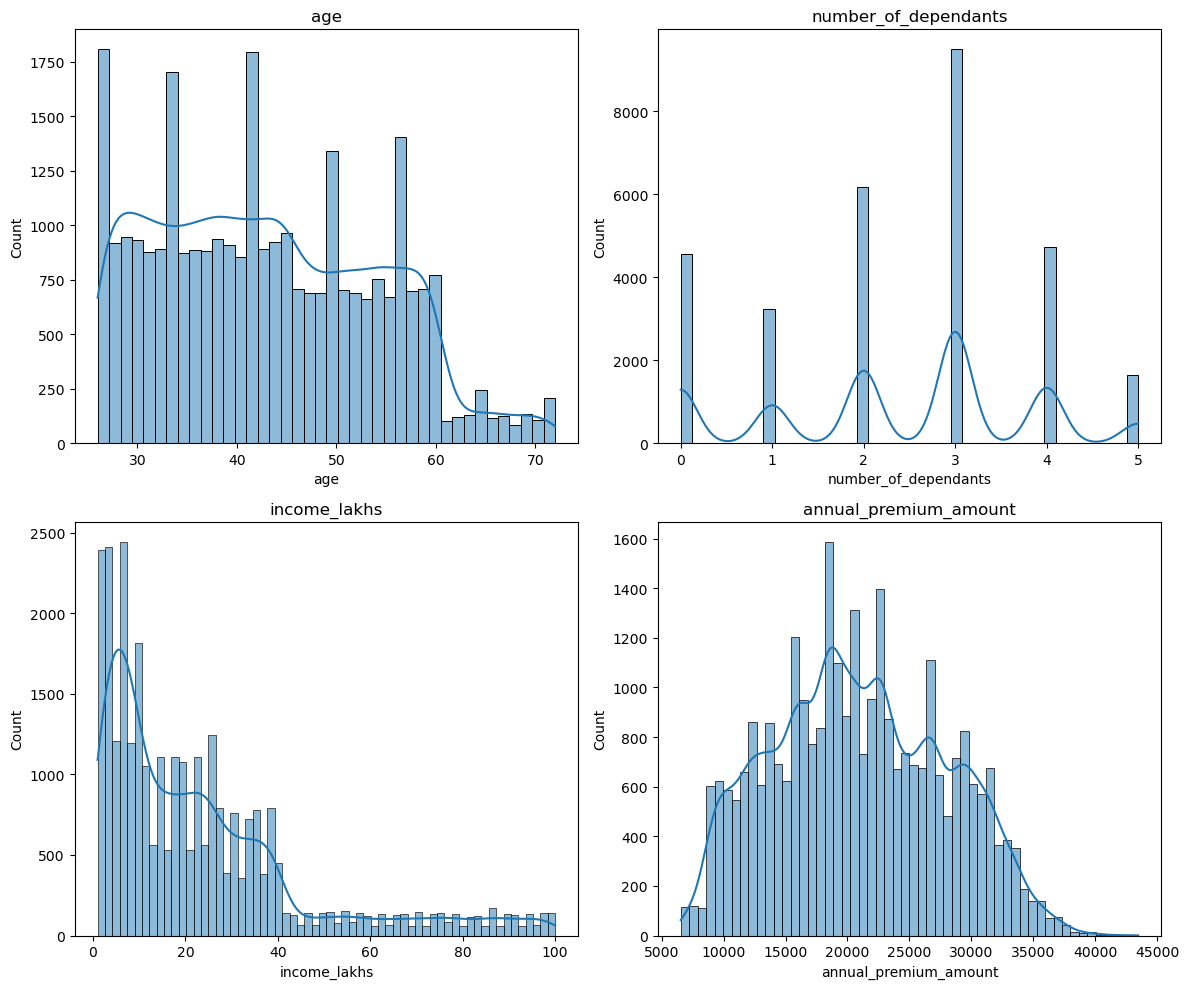

In [25]:


fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 subplot grid
axes = axes.flatten()  # Flatten to make indexing easier

for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i])  # Assign each plot to a subplot
    axes[i].set_title(col)  # Add column name as title
    

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

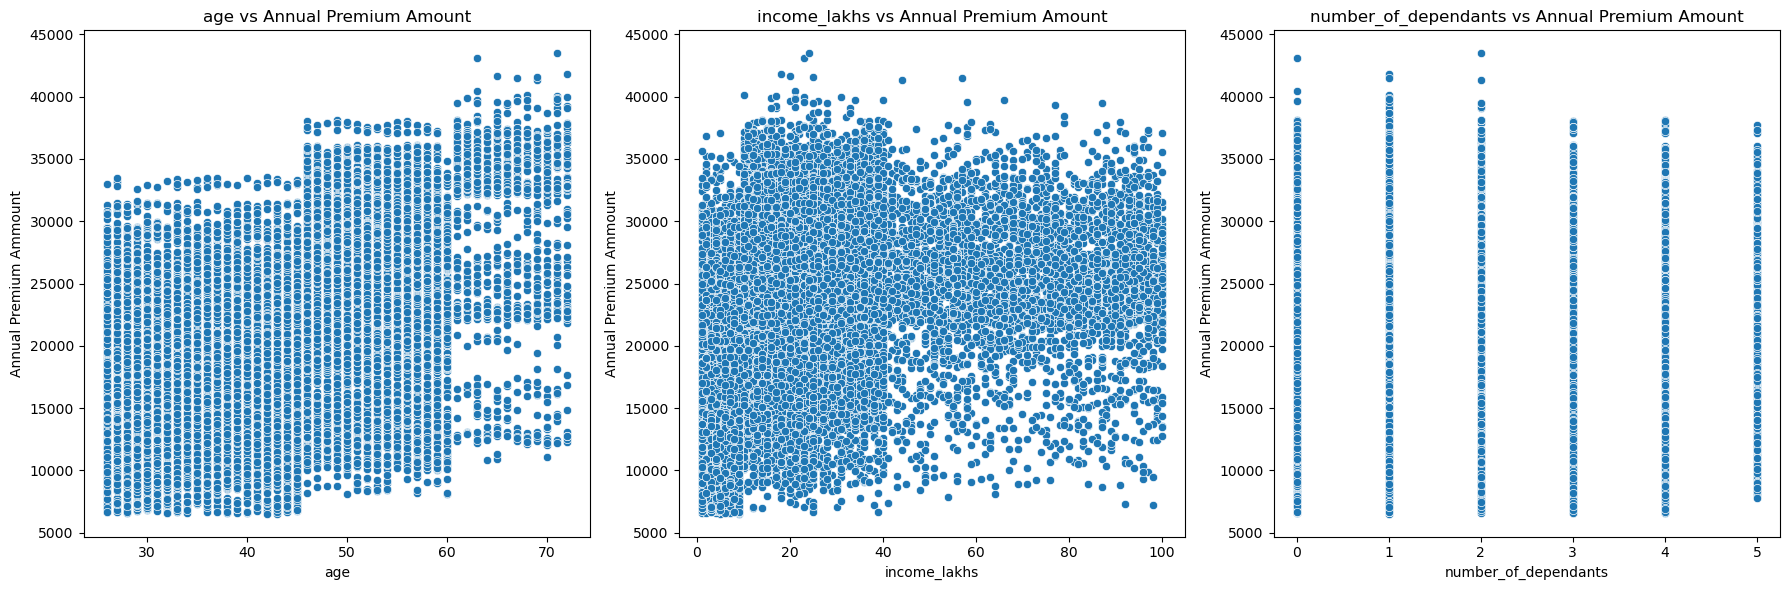

In [26]:
numeric_features = ['age' , 'income_lakhs' , 'number_of_dependants']

fig , axes = plt.subplots(1 , len(numeric_features) , figsize = (18,6))
axes = axes.flatten()

for i , column in enumerate(numeric_features):
    sns.scatterplot(x = df2[column] , y = df2["annual_premium_amount"] , ax= axes[i])
    axes[i].set_title(f'{column} vs Annual Premium Amount')   
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Annual Premium Ammount")
    
plt.tight_layout()
plt.show()                

In [27]:
categorical_cols = df.select_dtypes(['object' , 'category']).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [28]:
for col in categorical_cols:
    print(col , ":" , df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [29]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking' : 'No Smoking'
    
} , inplace = True)
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [30]:
pct_count = df2['gender'].value_counts(normalize = True)
pct_count

gender
Male      0.549125
Female    0.450875
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

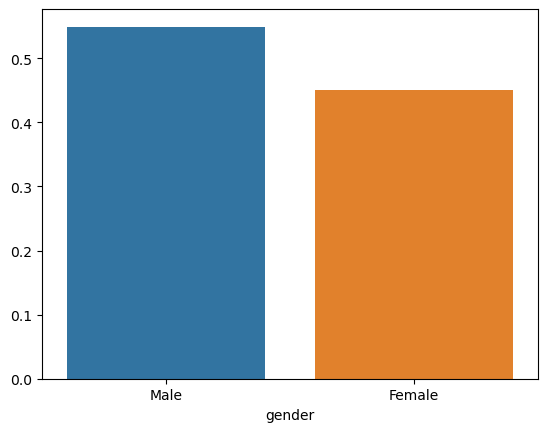

In [31]:
sns.barplot(x = pct_count.index , y = pct_count.values)

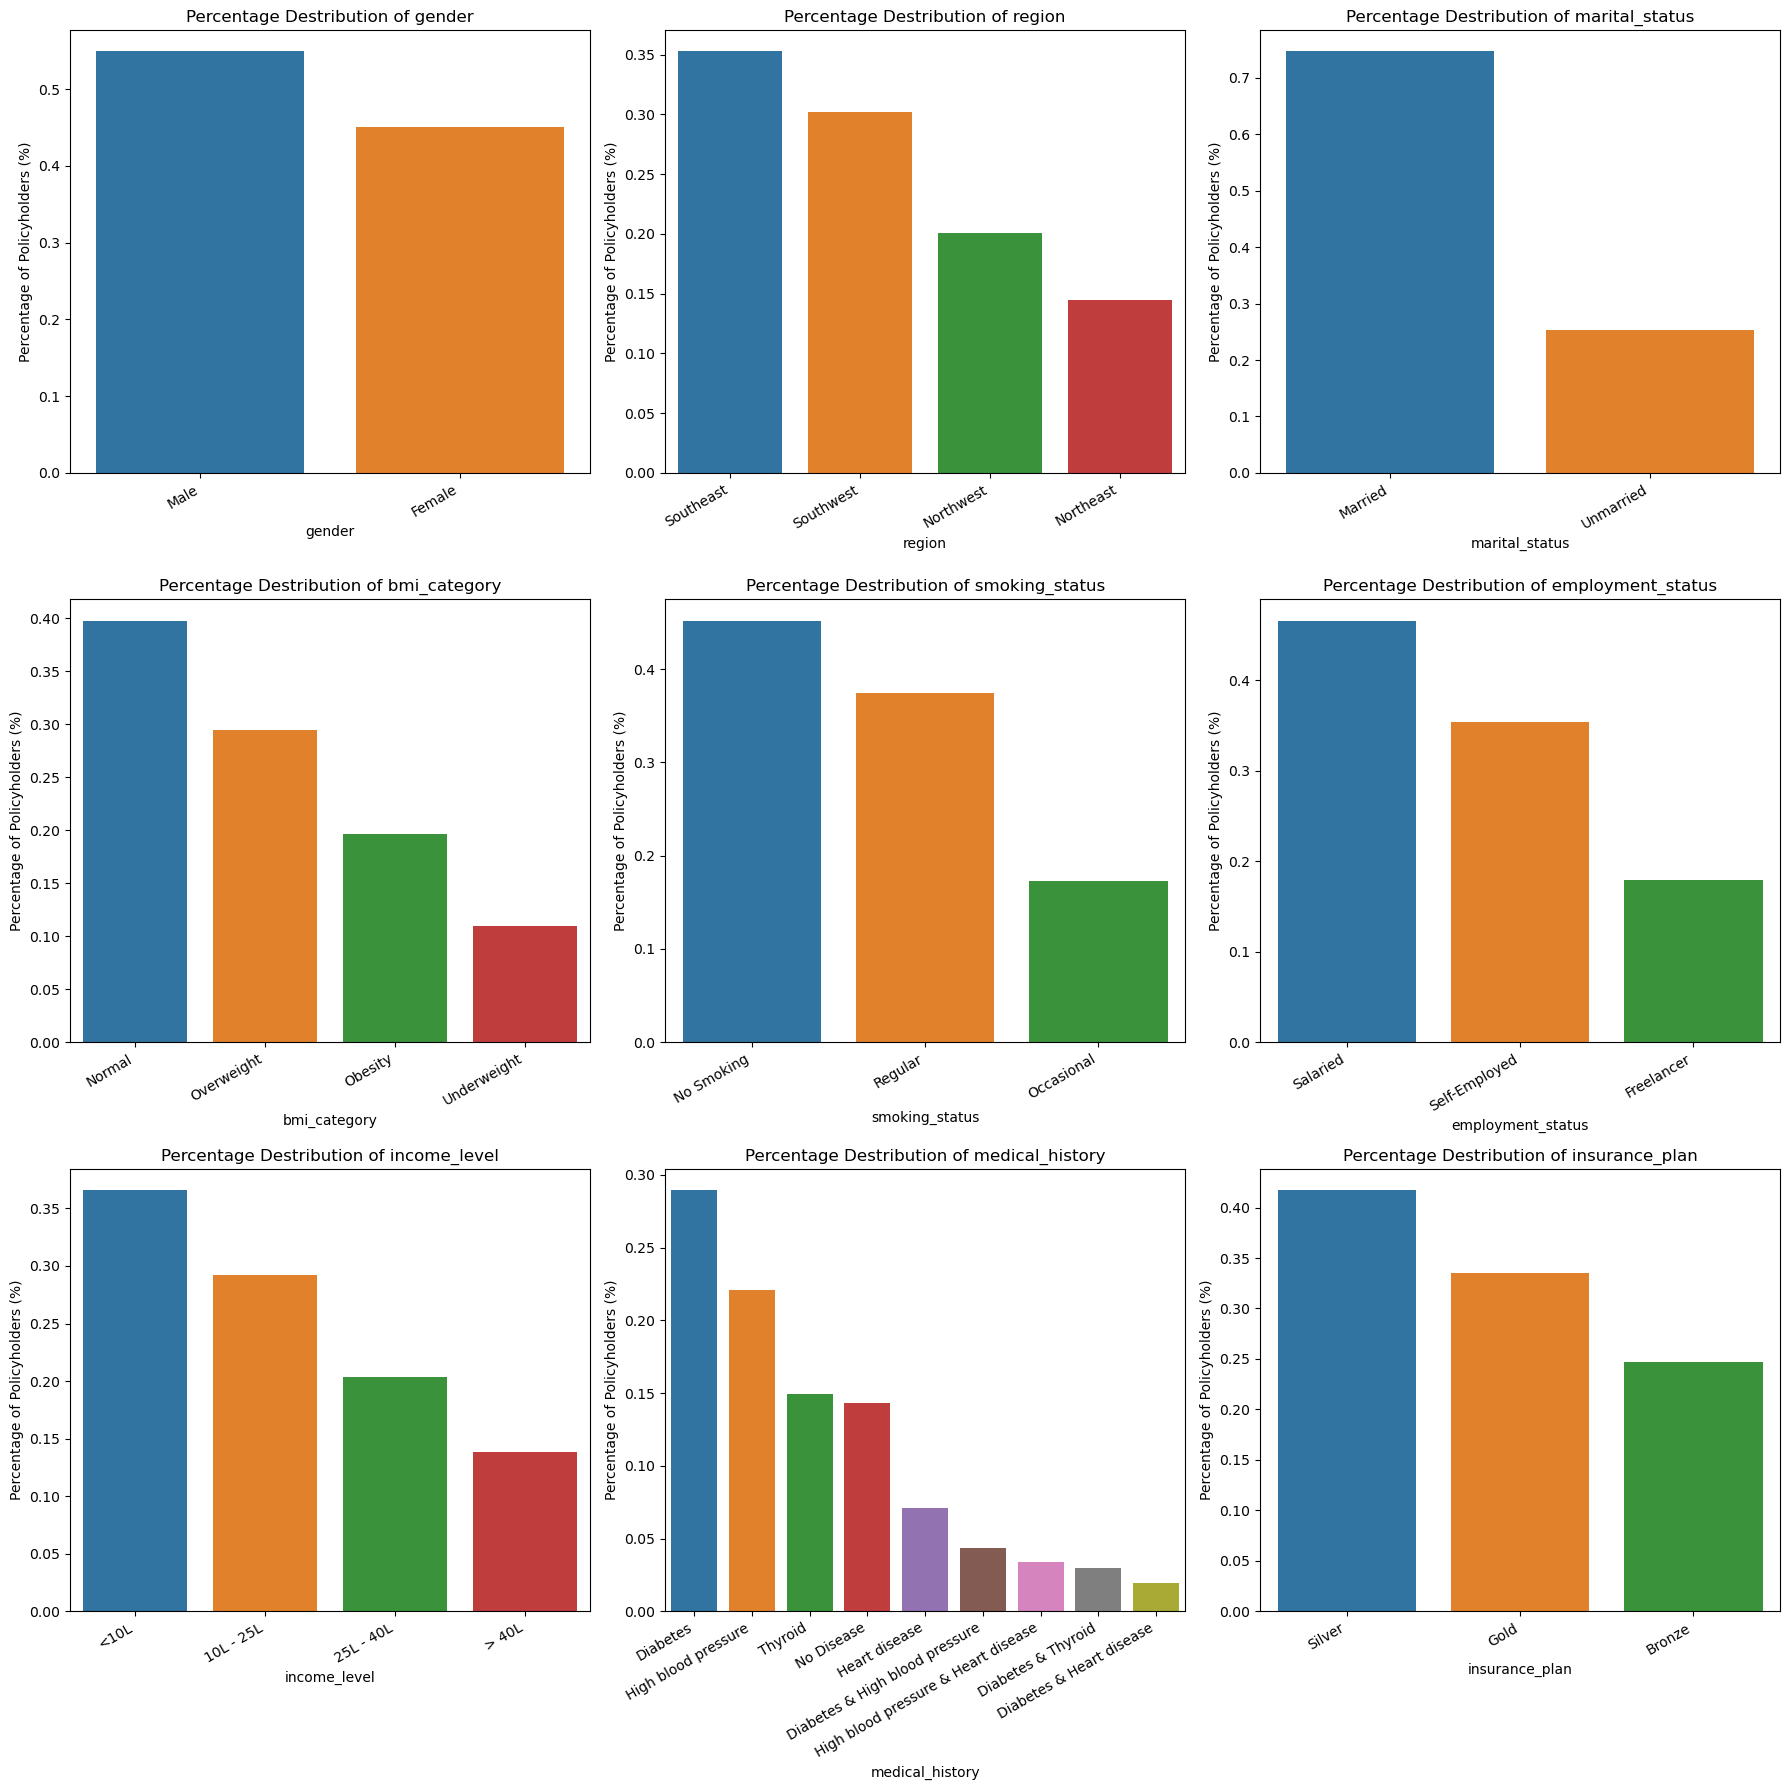

In [32]:
fig , axes = plt.subplots(3,3 , figsize =(18,18))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    pct_count = df2[col].value_counts(normalize = True)
    sns.barplot(x = pct_count.index , y = pct_count.values , ax = axes[i])
    axes[i].set_title(f'Percentage Destribution of {col}')
    axes[i].set_ylabel('Percentage of Policyholders (%)')
    axes[i].set_xlabel(col)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30, ha="right", fontsize=10)
plt.tight_layout()
plt.show()
    
    

In [33]:
crosstab = pd.crosstab(df2['income_level'] , df2['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,799,3554,4354
25L - 40L,301,2631,3142
<10L,6054,527,4341
> 40L,214,3287,618


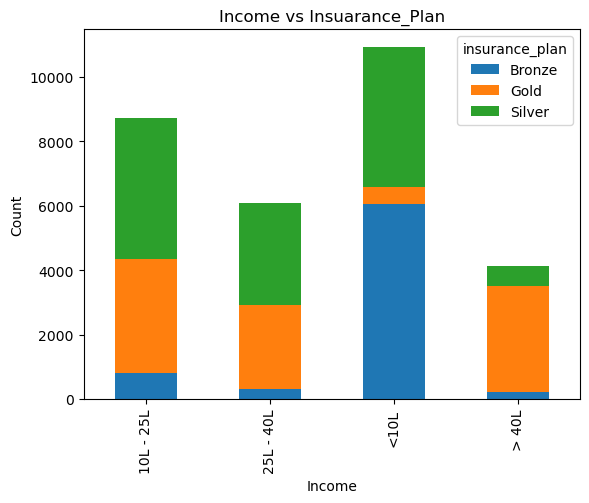

In [34]:
crosstab.plot(kind = 'bar' , stacked = True)
plt.title("Income vs Insuarance_Plan")
plt.ylabel("Count")
plt.xlabel("Income")
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

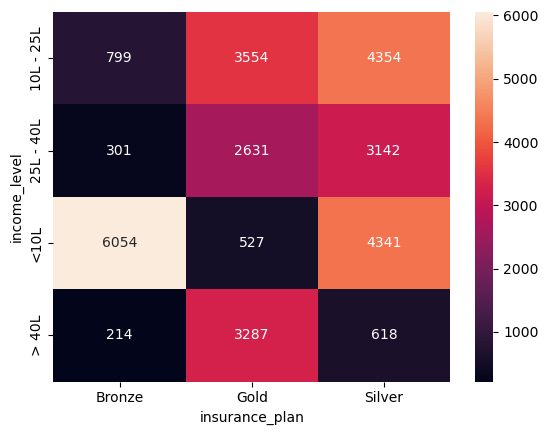

In [35]:
sns.heatmap(crosstab , annot =True , fmt = 'd')

## 2). Feature Engineering

In [36]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [37]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [38]:
risk_scores = {
    "diabetes" : 6 , 
    "heart disease":8,
    "high blood pressure" : 6,
    "thyroid" : 5 , 
    "no disease" : 0,
    "none":0
}

df2[['disease1' ,'disease2']] = df2['medical_history'].str.split(" & " , expand = True).apply(lambda x: x.str.lower())
# (split) devide column value by & and (expand) add to two columns
df2.head(2)



,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None


In [39]:
df2['disease1'].fillna('none' , inplace = True)
df2['disease2'].fillna('none' , inplace = True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)
    
min_score = df2['total_risk_score'].min()
max_score = df2['total_risk_score'].max()
                
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


In [40]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [41]:
df2["insurance_plan"] = df["insurance_plan"].map({'Bronze' : 1 , 'Silver' : 2 , 'Gold' : 3})
df2["insurance_plan"].unique()

array([1, 2, 3], dtype=int64)

In [42]:
df2["income_level"] = df["income_level"].map({'<10L' : 1 , '10L - 25L':2 , '25L - 40L':3 , '> 40L':4})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,2,14,Diabetes,1,15610,diabetes,none,6,0.428571


In [43]:
nominal_cols = ['gender','region','marital_status','bmi_category' , 'smoking_status','employment_status']

df3 = pd.get_dummies(df2 , columns = nominal_cols , drop_first=True , dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,diabetes,none,6,...,0,0,0,1,0,0,1,0,0,1


In [44]:
df4 = df3.drop(['medical_history' , 'disease1','disease2','total_risk_score'],axis = 1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


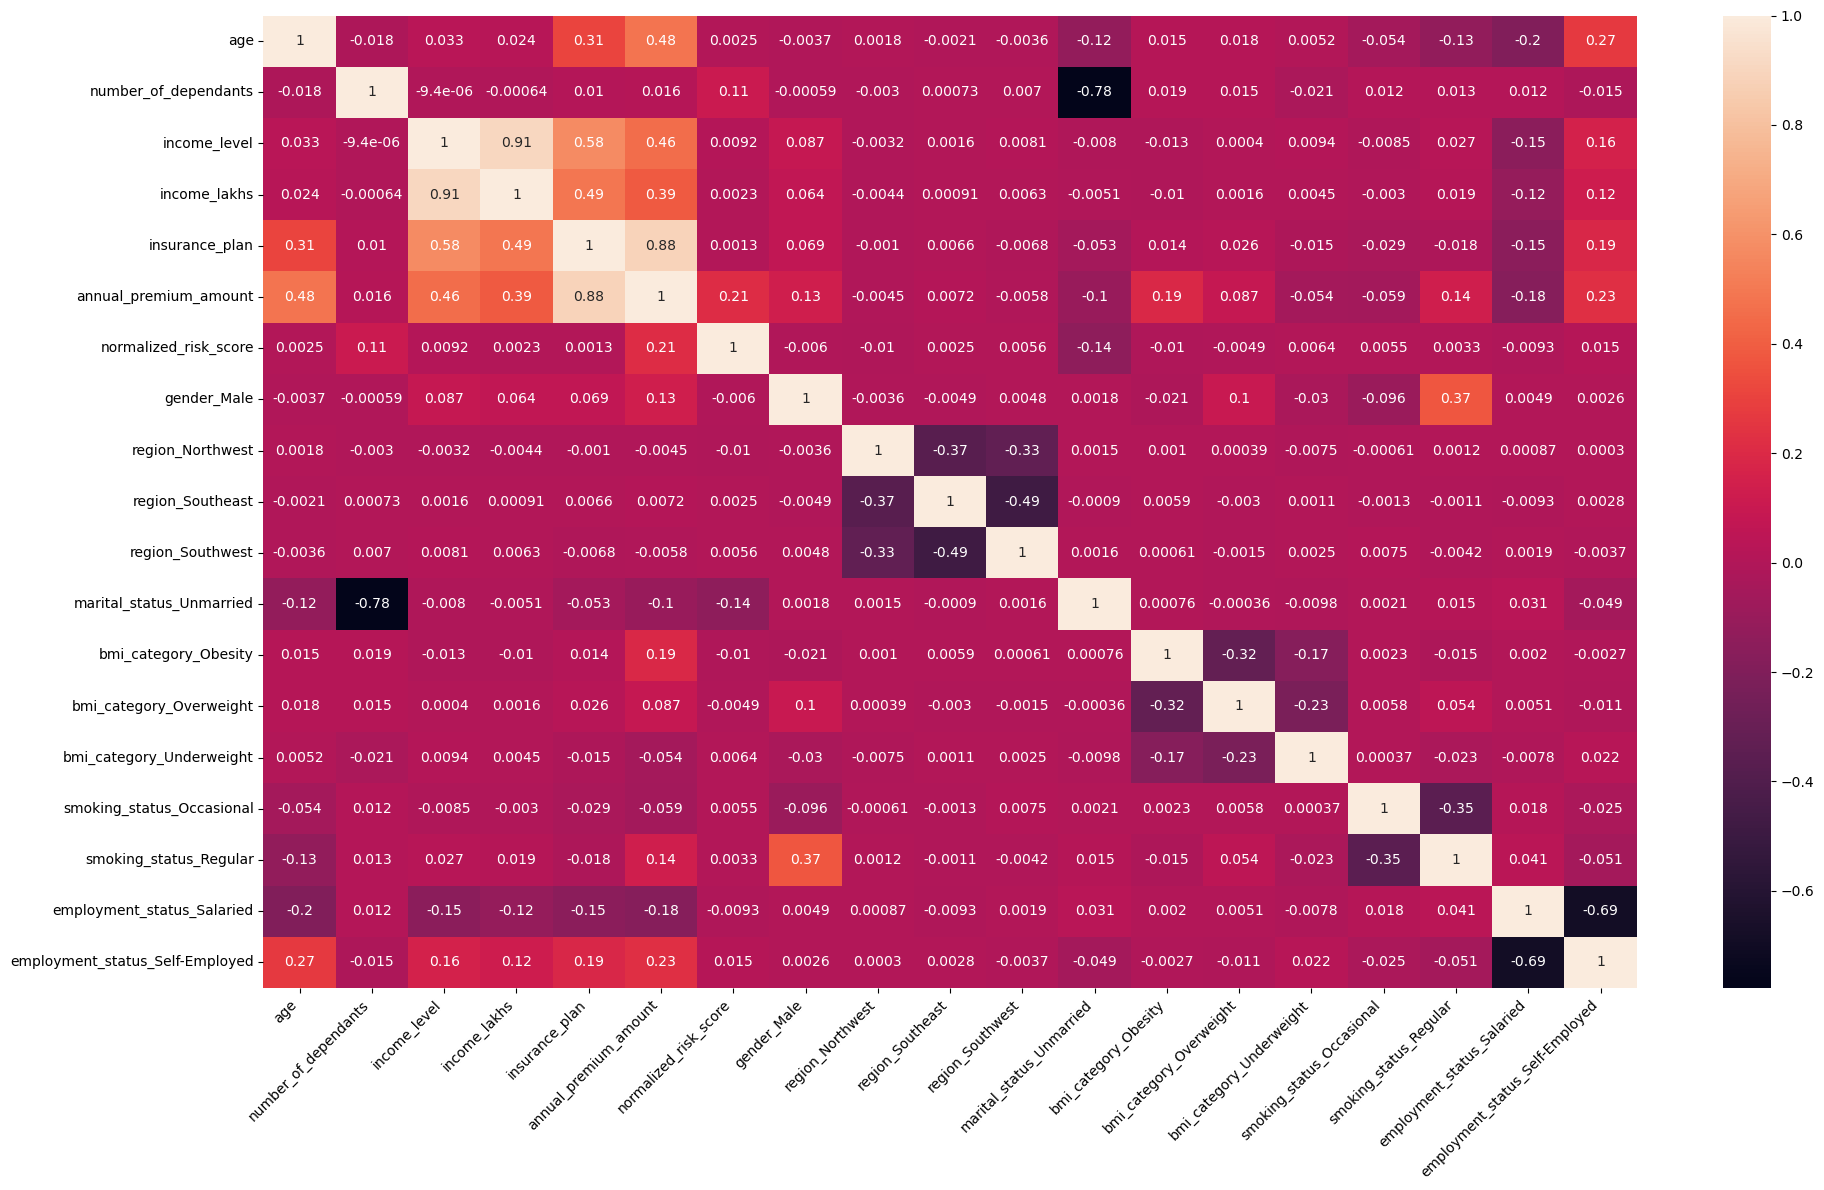

In [45]:
cm = df4.corr()      # correlation matrix

plt.figure(figsize =(20,12))
sns.heatmap(cm , annot = True)
plt.xticks(rotation =45 , ha ='right')
plt.yticks(rotation = 0 )
plt.tight_layout()
plt.show()

In [46]:
X = df4.drop('annual_premium_amount',axis = 1)
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values , i) for i in range(data.shape[1])]
    return vif_df


In [48]:
calculate_vif(X)

,column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,normalized_risk_score,3.810619
6,gender_Male,2.599098
7,region_Northwest,2.123965
8,region_Southeast,2.980842
9,region_Southwest,2.710097


In [49]:
calculate_vif(X.drop('income_level',axis = 1))  # two column have vif greater thn 10 , firstly remove highest vif and recheck




,column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,normalized_risk_score,3.808345
5,gender_Male,2.591439
6,region_Northwest,2.123277
7,region_Southeast,2.979899
8,region_Southwest,2.708641
9,marital_status_Unmarried,2.345757


In [50]:
X_reduced = X.drop('income_level',axis = 1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


## 3). Model Training

In [51]:
X_train ,X_test , y_train ,y_test = train_test_split(X_reduced , y ,test_size = 0.3 , random_state = 10 )

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test :", y_test.shape)

X_train : (20875, 17)
X_test : (8947, 17)
y_train : (20875,)
y_test : (8947,)


In [52]:
model_lr = LinearRegression()
model_lr.fit(X_train , y_train)

train_score = model_lr.score(X_train , y_train)
test_score = model_lr.score(X_test , y_test)

train_score , test_score

(0.9534163989489616, 0.9538448451629948)

In [53]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test , y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE :", mse_lr , " RMSE : ",rmse_lr)

Linear Regression ==> MSE : 2183844.360312456  RMSE :  1477.7835972538253


In [54]:
model_lr.intercept_

5935.981289344594

In [55]:
model_lr.coef_

array([ 7016.23932829, -1311.76470171,  -708.19336921, 14835.98820801,
        6053.6241234 ,    37.55826883,   -55.25087215,   -19.62254288,
         -22.28967559,  -700.32019985,  3926.8127061 ,  1979.45604663,
         612.86623617,   837.3951011 ,  2800.66184334,   -45.49136706,
         243.07842087])

In [56]:
feature_importance = model_lr.coef_

coef_df = pd.DataFrame(feature_importance , index = X_test.columns , columns =['Coefficients'])
coef_df = coef_df.sort_values(by ='Coefficients',ascending = True)
coef_df


,Coefficients
number_of_dependants,-1311.764702
income_lakhs,-708.193369
marital_status_Unmarried,-700.320200
region_Northwest,-55.250872
employment_status_Salaried,-45.491367
region_Southwest,-22.289676
region_Southeast,-19.622543
gender_Male,37.558269
employment_status_Self-Employed,243.078421
bmi_category_Underweight,612.866236


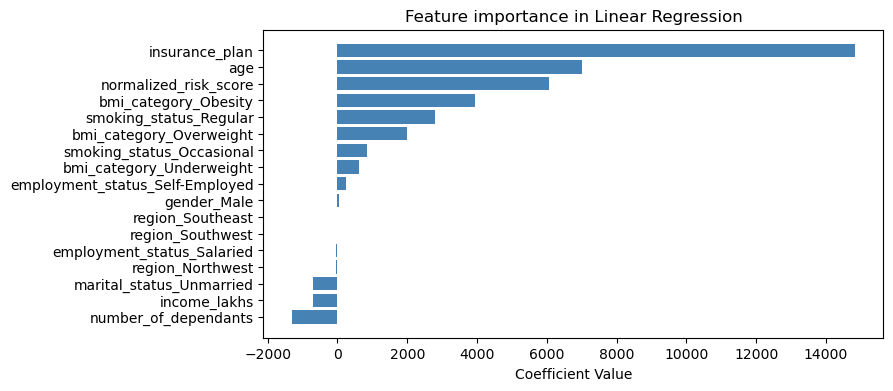

In [57]:
plt.figure(figsize = (8,4))
plt.barh(coef_df.index , coef_df["Coefficients"] , color = 'steelblue')
plt.xlabel('Coefficient Value')
plt.title("Feature importance in Linear Regression")
plt.show()

In [58]:
model_rg = Ridge()
model_rg.fit(X_train , y_train)

train_score = model_rg.score(X_train , y_train)
test_score = model_rg.score(X_test , y_test)

train_score , test_score


(0.9534162332209687, 0.9538456995663842)

In [59]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train , y_train)

train_score = model_xgb.score(X_train , y_train)
test_score = model_xgb.score(X_test , y_test)

train_score , test_score

(0.9986370761718086, 0.9979538491004899)

In [60]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test , y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE :", mse_xgb , " RMSE : ",rmse_xgb)

XGBoost Regression ==> MSE : 96814.21540071907  RMSE :  311.14982789762087


In [61]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [62]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_


0.9970577807993951

In [63]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [64]:
random_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [65]:
best_model = random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

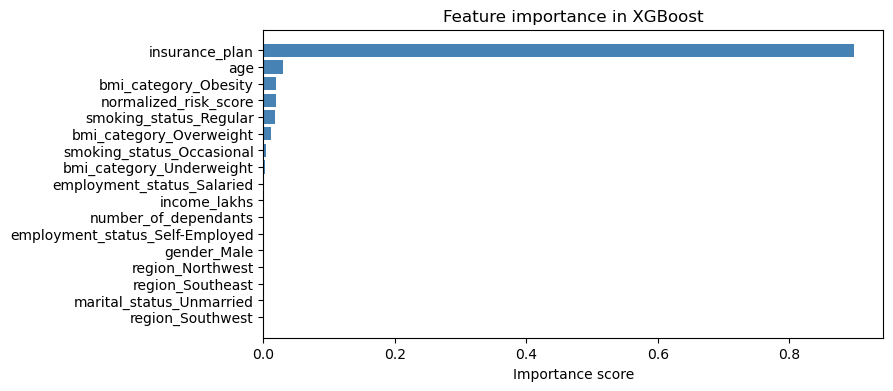

In [66]:
feature_importances = best_model.feature_importances_
feature_importances

coef_df = pd.DataFrame(feature_importances , index = X_test.columns , columns =['Coefficients'])
coef_df = coef_df.sort_values(by ='Coefficients',ascending = True)

plt.figure(figsize = (8,4))
plt.barh(coef_df.index , coef_df["Coefficients"] , color = 'steelblue')
plt.xlabel('Importance score')
plt.title("Feature importance in XGBoost")
plt.show()


## 4). Error Analysis

In [67]:
# works with test data set

In [68]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals * 100 / y_test

results_df = pd.DataFrame({
    'actual' : y_test,
    'predicated' : y_pred,
    'diff' : residuals,
    'diff_pct' : residuals_pct
})

results_df.head()

,actual,predicated,diff,diff_pct
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.751953,-83.248047,-0.366183
19932,21198,21581.894531,383.894531,1.810994
29643,9100,9425.934570,325.934570,3.581699
17076,26434,26691.470703,257.470703,0.974013


<Axes: xlabel='diff_pct', ylabel='Count'>

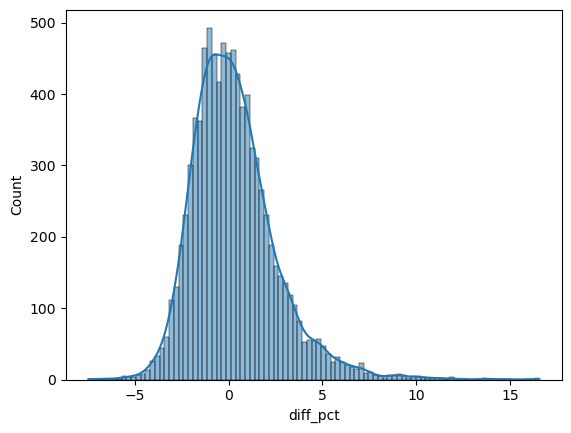

In [69]:
sns.histplot(results_df['diff_pct'] , kde = True)

In [70]:
extreme_error_threshold = 10        # our maximum error percentage is 10

extreme_results_df = results_df[np.abs(results_df.diff_pct) > extreme_error_threshold]
extreme_results_df

,actual,predicated,diff,diff_pct
14286,6845,7621.263672,776.263672,11.340594
27518,8502,9425.934570,923.934570,10.867261
9285,6872,7621.263672,749.263672,10.903138
7547,6538,7621.263672,1083.263672,16.568732
21910,6651,7621.263672,970.263672,14.588237
12189,6571,7621.263672,1050.263672,15.983316
21141,10722,11841.492188,1119.492188,10.441076
16263,8206,9063.517578,857.517578,10.449885
8216,6635,7621.263672,986.263672,14.864562
13973,10583,11841.492188,1258.492188,11.891639


In [71]:
results_df.shape    

(8947, 4)

In [86]:
extreme_results_df.shape

(29, 4)

In [72]:
extreme_errors_pct = extreme_results_df.shape[0] * 100 / results_df.shape[0]
extreme_errors_pct

0.32413099362914943

In [73]:
# it means 30% of predictions , error is higher than 10% ( on test data)

In [74]:
extreme_results_df_50 = results_df[np.abs(results_df.diff_pct) > 50]
extreme_errors_pct_50 = extreme_results_df.shape[0] * 100 / results_df.shape[0]
extreme_results_df_50.shape[0] , extreme_errors_pct_50

(0, 0.32413099362914943)

In [75]:
# it mean 549 data rows of test data have error grater than 50%

In [76]:
extreme_results_df.index     # indexes of test records that have error graer than 10%


Index([14286, 27518,  9285,  7547, 21910, 12189, 21141, 16263,  8216, 13973,
        9150, 24145, 18522,  6163, 18681, 19145, 21455, 22666,  7508, 10741,
        6517, 18834, 13744, 24119,  2695, 25658, 11019, 14037,  7654],
      dtype='int64')

In [77]:
extreme_errors_df = X_test.loc[extreme_results_df.index]  #  test records that have error grater than 10%
extreme_errors_df




,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14286,0.021739,0.6,0.050505,0.0,0.000000,1,1,0,0,1,0,0,0,0,0,1,0
27518,0.304348,0.6,0.080808,0.0,0.357143,1,1,0,0,0,0,0,0,0,0,0,1
9285,0.326087,0.6,0.010101,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
7547,0.347826,0.2,0.080808,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,1,0
21910,0.043478,0.6,0.020202,0.0,0.000000,1,0,1,0,0,0,0,0,0,0,0,0
12189,0.043478,0.6,0.060606,0.0,0.000000,1,0,0,1,0,0,0,0,0,0,1,0
21141,0.239130,0.6,0.000000,0.0,0.857143,0,0,0,1,0,0,0,0,0,0,0,1
16263,0.673913,0.6,0.383838,0.0,0.000000,1,1,0,0,0,0,0,0,0,0,0,0
8216,0.152174,0.4,0.010101,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,1,0
13973,0.152174,0.8,0.030303,0.0,0.857143,0,1,0,0,0,0,0,0,0,0,0,1


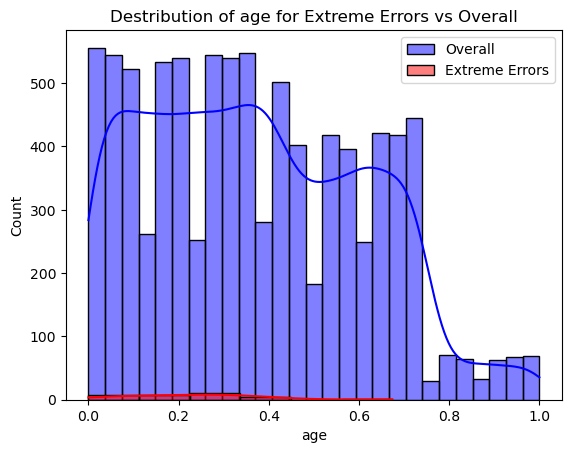

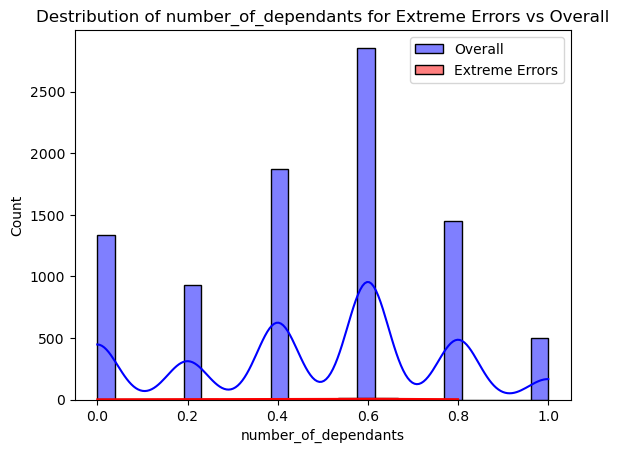

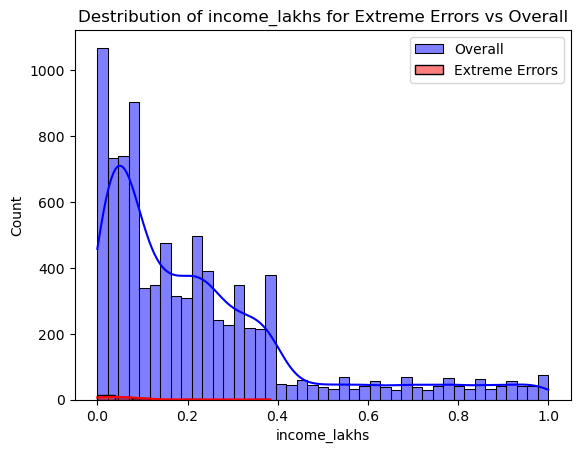

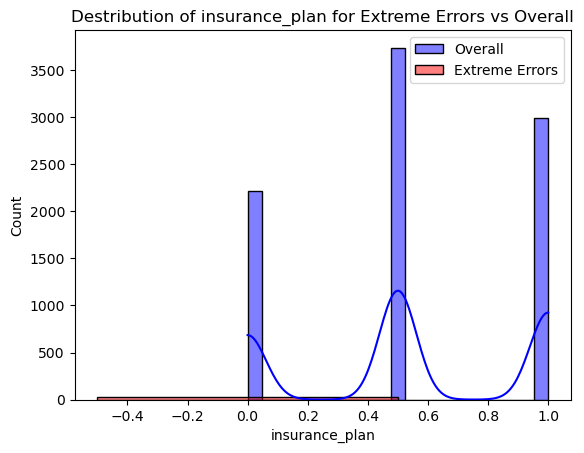

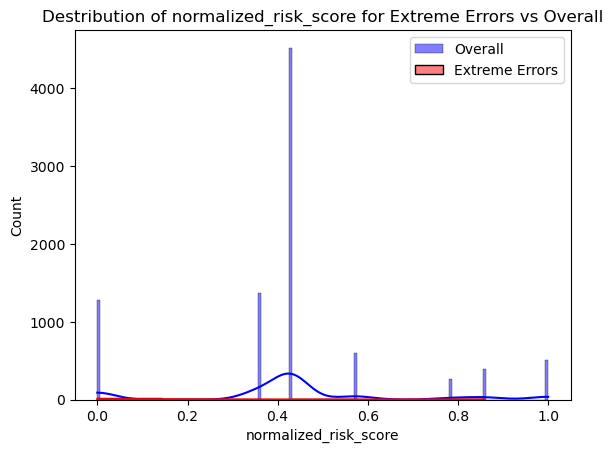

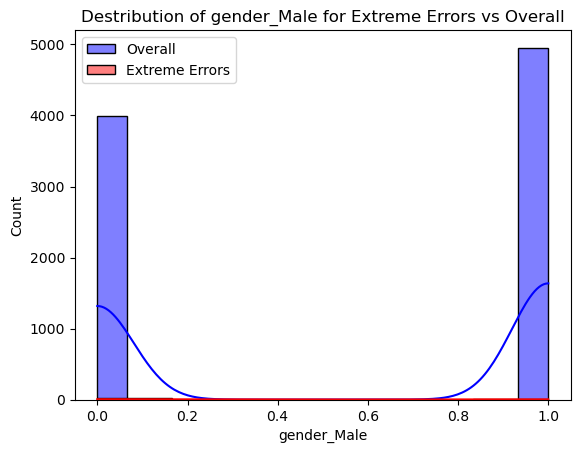

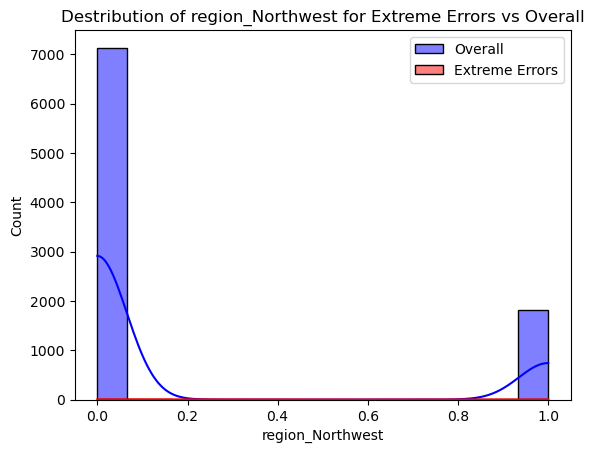

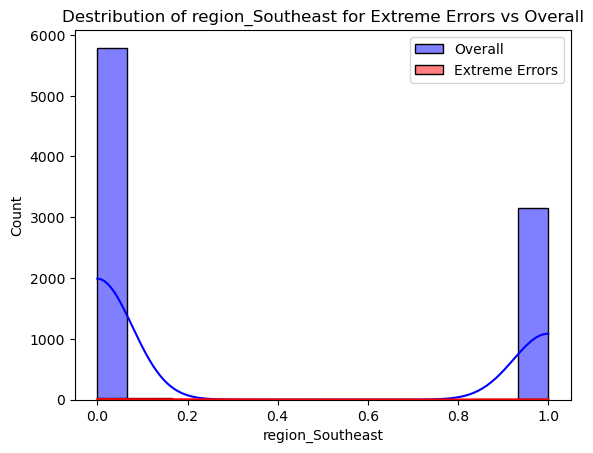

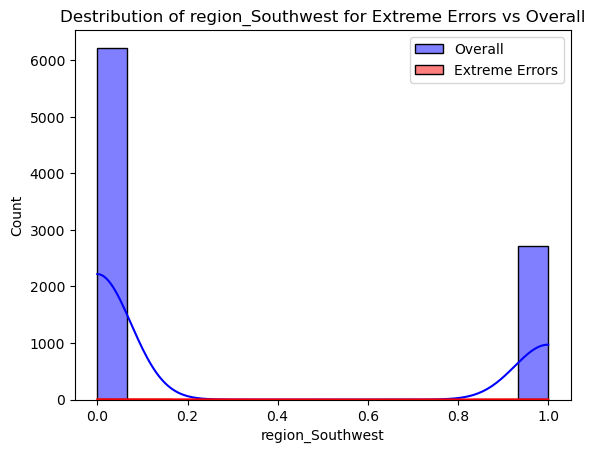

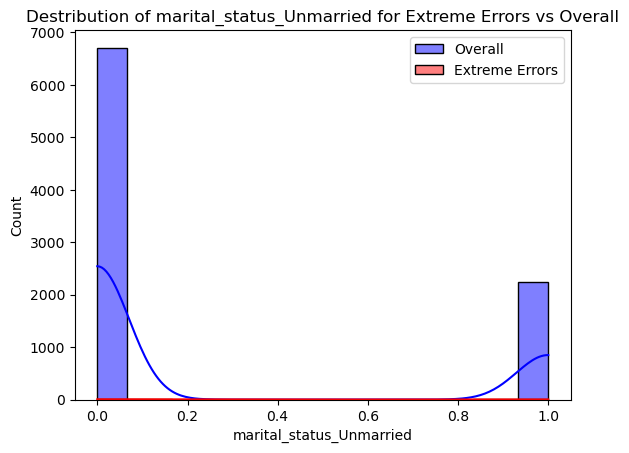

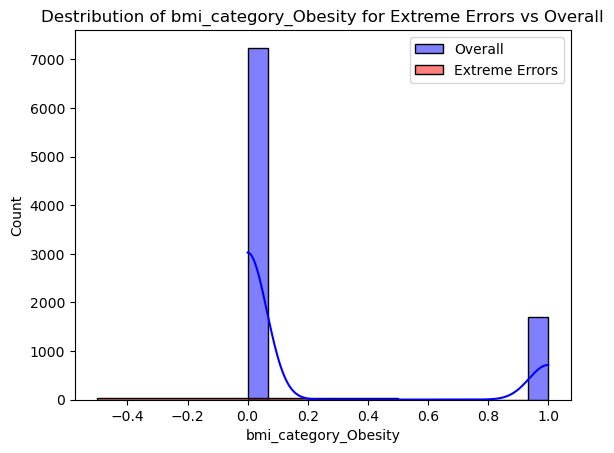

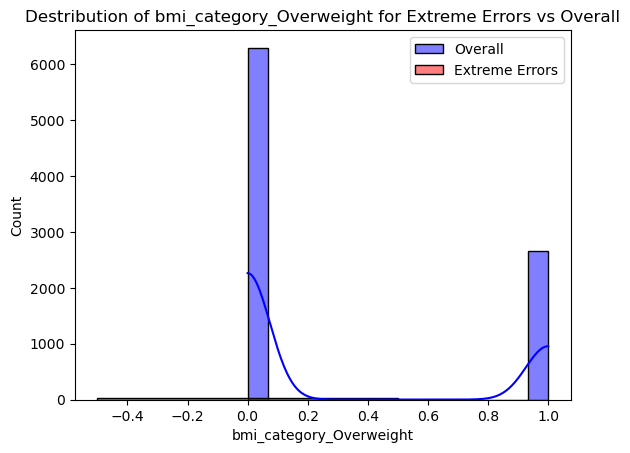

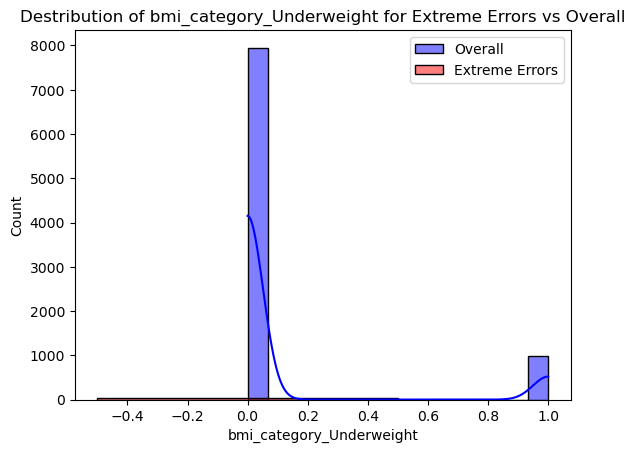

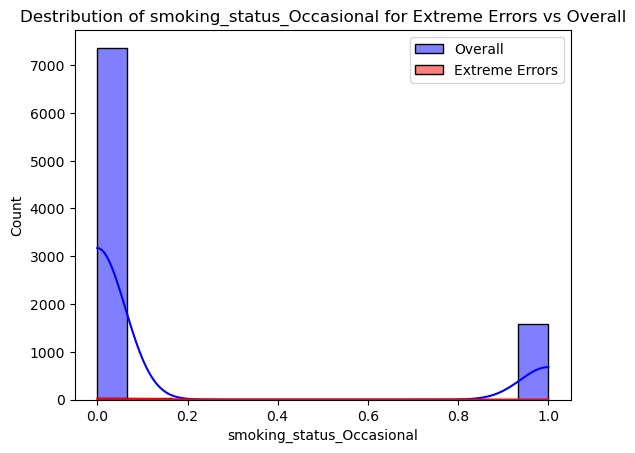

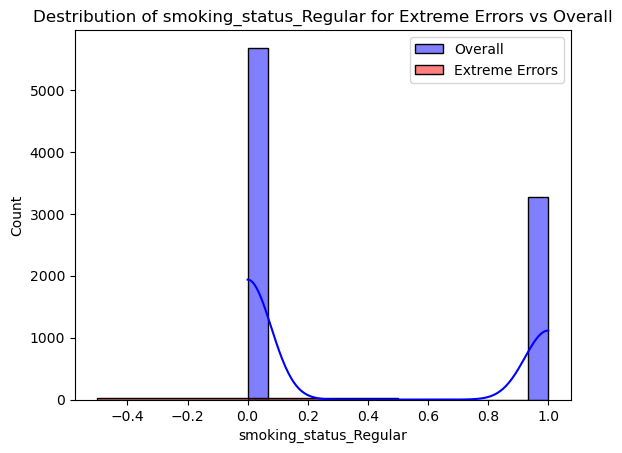

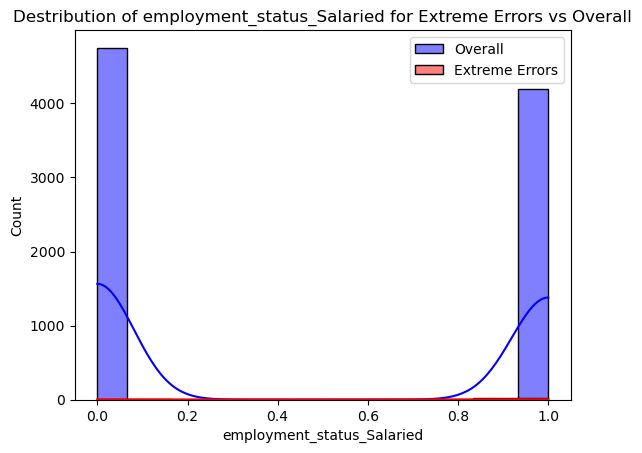

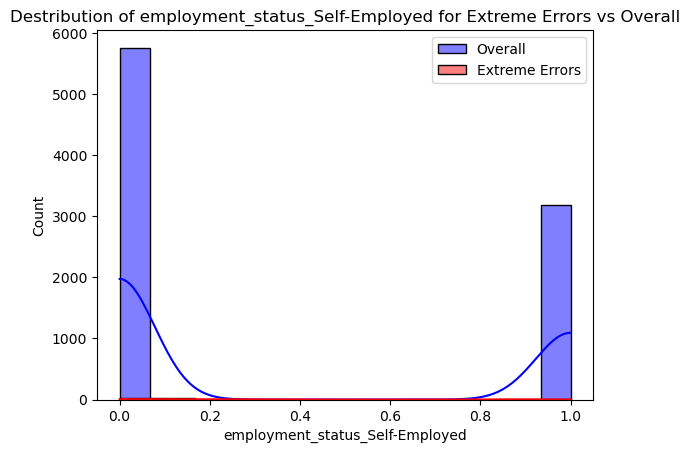

In [78]:
for col in X_test.columns:
    sns.histplot(X_test[col] ,label = "Overall",color = 'blue', kde = True)
    sns.histplot(extreme_errors_df[col] ,label = "Extreme Errors",color ='red', kde = True)
    plt.title(f'Destribution of {col} for Extreme Errors vs Overall')
    plt.legend()
    plt.show()
        

In [79]:
# insight : problem with lower age group

<Axes: xlabel='age', ylabel='Count'>

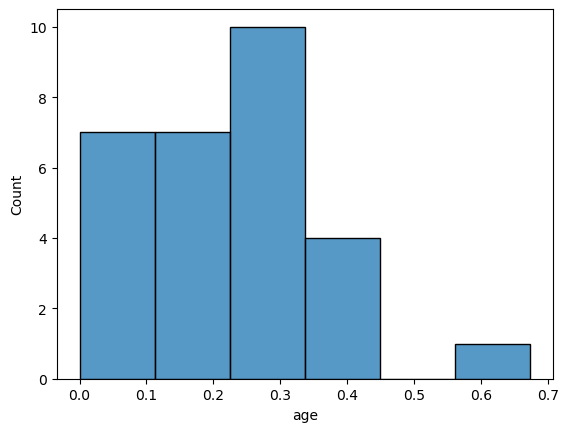

In [80]:
sns.histplot(extreme_errors_df.age)

In [81]:
# we want see real ages  , going to reversed that , scaled data before


df_reversed = pd.DataFrame()

extreme_errors_df['income_level'] = -1    # we want add because we doped that column after scaling
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed





,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,27.0,3.0,-2.0,6.0,1.0
1,40.0,3.0,-2.0,9.0,1.0
2,41.0,3.0,-2.0,2.0,1.0
3,42.0,1.0,-2.0,9.0,1.0
4,28.0,3.0,-2.0,3.0,1.0
5,28.0,3.0,-2.0,7.0,1.0
6,37.0,3.0,-2.0,1.0,1.0
7,57.0,3.0,-2.0,39.0,1.0
8,33.0,2.0,-2.0,2.0,1.0
9,33.0,4.0,-2.0,4.0,1.0


<Axes: xlabel='age', ylabel='Count'>

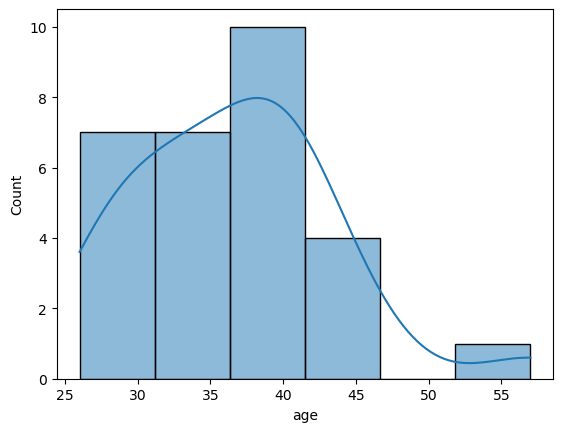

In [82]:
sns.histplot(df_reversed['age'] , kde =True)

In [83]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,29.000000,29.000000,29.0,29.000000,29.0
mean,36.586207,2.241379,-2.0,6.862069,1.0
std,6.811321,1.184880,0.0,7.619168,0.0
min,26.000000,0.000000,-2.0,1.000000,1.0
25%,32.000000,1.000000,-2.0,3.000000,1.0
50%,37.000000,3.000000,-2.0,5.000000,1.0
75%,40.000000,3.000000,-2.0,9.000000,1.0
max,57.000000,4.000000,-2.0,39.000000,1.0


In [84]:
for i in np.arange(0.75, 1.0, 0.01):
    qv = (round(i, 2))
    print(f"Quantile : {qv}   Age up to : {df_reversed['age'].quantile(qv)}")

Quantile : 0.75   Age up to : 40.0
Quantile : 0.76   Age up to : 40.28
Quantile : 0.77   Age up to : 40.56
Quantile : 0.78   Age up to : 40.84
Quantile : 0.79   Age up to : 41.0
Quantile : 0.8   Age up to : 41.0
Quantile : 0.81   Age up to : 41.0
Quantile : 0.82   Age up to : 41.0
Quantile : 0.83   Age up to : 41.239999999999995
Quantile : 0.84   Age up to : 41.519999999999996
Quantile : 0.85   Age up to : 41.8
Quantile : 0.86   Age up to : 42.08
Quantile : 0.87   Age up to : 42.36
Quantile : 0.88   Age up to : 42.64
Quantile : 0.89   Age up to : 42.92
Quantile : 0.9   Age up to : 43.4
Quantile : 0.91   Age up to : 43.96
Quantile : 0.92   Age up to : 44.52
Quantile : 0.93   Age up to : 45.040000000000006
Quantile : 0.94   Age up to : 45.32
Quantile : 0.95   Age up to : 45.599999999999994
Quantile : 0.96   Age up to : 45.879999999999995
Quantile : 0.97   Age up to : 47.760000000000005
Quantile : 0.98   Age up to : 50.839999999999975
Quantile : 0.99   Age up to : 53.91999999999999


In [85]:
# insight : 95 % of extreme error records have age 25 or less